Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv

### Этапы работы:

1) Преобразуйте данные:

a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;

b. закодируйте категориальные переменные числовыми значениями по необходимости.

2) Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.

3) Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.

4) Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

5) Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.

6) Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.

7) Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.

8) *Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.

9) Сформулируйте выводы по проделанной работе:

a. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?

b. *может ли ROC-кривая проходить ниже диагонали?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
data = pd.read_csv('athletes.csv')
data.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


### Очистка и преобразование данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [4]:
data.duplicated().sum()

0

In [5]:
data[(data['weight'].isna() | data['height'].isna()) & ((data['gold'] != 0) | (data['silver'] != 0) | (data['bronze'] != 0))]

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
57,153457,Abdullahi Shehu,NGR,male,3/12/93,1.70,NaN,football,0,0,1
108,75289002,Adilbek Niyazymbetov,KAZ,male,5/19/89,1.80,NaN,boxing,0,1,0
552,791528062,Alonzo Russell,BAH,male,2/8/92,NaN,NaN,athletics,0,0,1
586,557518345,Amanda Kurtovic,NOR,female,7/25/91,1.75,NaN,handball,0,0,1
628,389896499,Aminu Umar,NGR,male,3/6/95,1.72,NaN,football,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
10919,610704045,Vladimir Nikitin,RUS,male,3/25/90,1.65,NaN,boxing,0,0,1
11014,213332524,William Ekong,NGR,male,9/1/93,1.75,NaN,football,0,0,1
11261,607223536,Yoel Segundo Finol,VEN,male,9/21/96,1.68,NaN,boxing,0,0,1
11370,86099624,Yulia Efimova,RUS,female,4/3/92,NaN,NaN,aquatics,0,2,0


#### Мы видим, что данные по росту и весу отсутствуют у 104 медалистов олимпиады. Так как всего на Олимпиаде было разыграно 306 комплектов наград, то удалив записи с пропусками, мы лишимся 11,5% всех, необходимых нам записей.

Для роста пропуски заменим средним с группировкой по полу и виду спорта

In [6]:
data['height'] = data.groupby(['sex', 'sport'], sort=False)['height'].apply(lambda x: x.fillna(round(x.mean(),2)))

Так как для бокса у нас отсутствуют данные о весе спортсменов, то заменим данные на основе пола и роста

In [7]:
data['weight'] = data.groupby(['sex', 'height'], sort=False)['weight'].apply(lambda x: x.fillna(round(x.mean(), 1)))

In [8]:
data[data['dob'].isna()]

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
8546,663676373,Pavel Sozykin,RUS,male,NaN,1.81,77.6,sailing,0,0,0


Остаётся одна запись с пропущенными значениями с id 663676373, удалим её

In [9]:
data.dropna(axis=0, inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11537 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11537 non-null  int64  
 1   name         11537 non-null  object 
 2   nationality  11537 non-null  object 
 3   sex          11537 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11537 non-null  float64
 6   weight       11537 non-null  float64
 7   sport        11537 non-null  object 
 8   gold         11537 non-null  int64  
 9   silver       11537 non-null  int64  
 10  bronze       11537 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1.1+ MB


Заменим дату рождения спортсмена на его возраст

In [11]:
data['dob'] = data['dob'].apply(lambda x: 116 - int(x.split('/')[2]))

Имя спортсмена и его id не несут пользы для нас, поэтому удалим их

In [12]:
data = data.drop(columns = ['id', 'name'])

Категориальный признак sex бинарен, поэтому для его преобразования используем функцию LabelEncoder, для nationality и sport применим функцию OneHotEncoder

In [13]:
data['sex'] = LabelEncoder().fit_transform(data['sex'])

In [14]:
onehotencoder = OneHotEncoder()
sport = onehotencoder.fit_transform(data[['sport']]).toarray()
sport = pd.DataFrame(sport, columns=onehotencoder.categories_[0])
nationality = onehotencoder.fit_transform(data[['nationality']]).toarray()
nationality = pd.DataFrame(nationality, columns=onehotencoder.categories_[0])
data = pd.concat([sport, nationality, data], axis=1)
data = data.drop(columns = ['sport', 'nationality'])
data.dropna(axis=0, inplace=True)

In [15]:
data.head()

,aquatics,archery,athletics,badminton,basketball,boxing,canoe,cycling,equestrian,fencing,...,YEM,ZAM,ZIM,sex,dob,height,weight,gold,silver,bronze
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,47.0,1.72,64.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,30.0,1.68,56.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,24.0,1.98,79.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,25.0,1.83,80.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,26.0,1.81,71.0,0.0,0.0,0.0


In [16]:
X = data[data.columns[:-3]]
y = data[['gold', 'silver', 'bronze']].apply(lambda x: 1 if ((x['gold'] > 0) | (x['silver'] > 0) | (x['bronze'] > 0)) else 0, axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [18]:
model = LogisticRegression(solver = 'newton-cg')
model.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [19]:
predictions = model.predict_proba(X_test)

In [20]:
model.score(X_train, y_train)

0.8397269180754227

In [21]:
model.score(X_test, y_test)

0.8448873483535528

In [22]:
fpr, tpr, thres = roc_curve(y_test, predictions[:, 1])

### Построение ROC-кривой с помощью функции sklearn metrics.roc_curve

Зададим данные для диагонального вектора, в качестве примера для сравнения

In [23]:
x_diag = [[0],[0.5],[1]]
y_diag = [[0],[0.5],[1]]

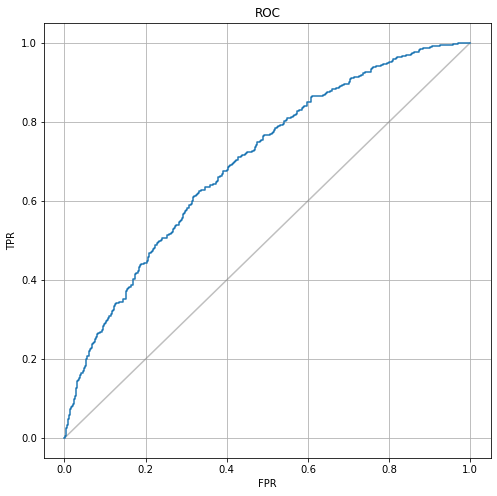

In [24]:
plt.figure(figsize=(8,8))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.plot(x_diag, y_diag, color='gray', alpha=0.5)
plt.plot(fpr, tpr)
plt.grid()

### Вычисление значения ROC-AUC метрики с помощью функции sklearn metrics.roc_auc_score

In [25]:
roc_auc_score(y_test, predictions[:, 1])

0.6979785523174892

### Подсчитаем метрики TPR, FPR вручную без импорта функций

In [26]:
def tpr_fpr(threshold, y_test):
    """
    Функция сравнивает предсказанные значения и значения из тестовой выборки
    в зависимости от значений, относит результаты в соответствии с матрицей ошибок
    """
    tp = np.equal(threshold, 1) & np.equal(y_test, 1)
    tn = np.equal(threshold, 0) & np.equal(y_test, 0)
    fp = np.equal(threshold, 1) & np.equal(y_test, 0)
    fn = np.equal(threshold, 0) & np.equal(y_test, 1)
    
    tpr = tp.sum() / (tp.sum() + fn.sum())
    fpr = fp.sum() / (fp.sum() + tn.sum())
    if tp.sum() + fp.sum() != 0:
        precision = tp.sum() / (tp.sum() + fp.sum())
    else:
        precision = 0

    return tpr, fpr, precision

In [27]:
def roc(probabilities, y_test, iter):
    """
    Функция считает roc
    """
    roc = np.array([])
    for i in range(iter + 1):
        threshold = np.greater_equal(probabilities, i / iter).astype(int)
        tpr, fpr, precision = tpr_fpr(threshold, y_test)
        roc = np.append(roc, [fpr, tpr, precision])

    return roc.reshape(-1, 3)

In [28]:
iter = 200
ROC = roc(predictions[:, 1], y_test, iter)

### Построение ROC-кривых вычисленных самостоятельно и с помощью библиотеки metrics.roc_curve

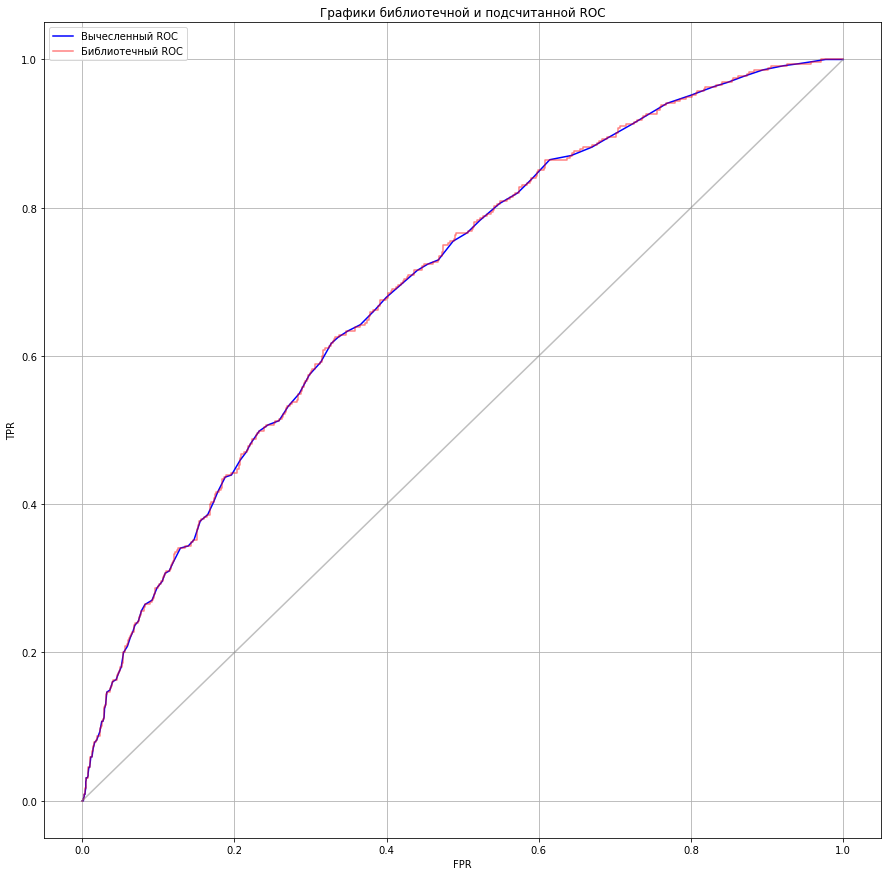

In [29]:
plt.figure(figsize=(15,15))
plt.plot(ROC[:,0],ROC[:,1], color='blue', label='Вычесленный ROC')
plt.plot(fpr, tpr, color='red', alpha=0.5, label='Библиотечный ROC')
plt.plot(x_diag, y_diag, color='gray', alpha=0.5)
plt.title('Графики библиотечной и подсчитанной ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend()

**Промежуточный вывод:** Графики посчитанные с помощью библитечной функции ROC и посчитанные самостоятельно совпадают почти на всём протяжении

### Построение график Precision-Recall, используя метрики

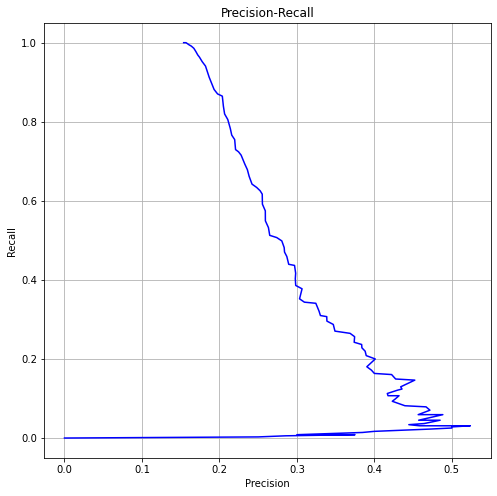

In [30]:
plt.figure(figsize=(8,8))
plt.plot(ROC[:,2], ROC[:,1], color='blue')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall')
plt.grid()

### Вычислите значение ROC-AUC метрики

In [31]:
auc(ROC[:,0],ROC[:,1])

0.6976951313616465

### Выводы:

**a)** На основании построенных графиков мы можем сказать, что модель показала неплохое качество. Если основываться только на метриках, то можно сказать, что модель хорошо справилась с задачей, так как мы предсказывали результат в виде спорта только на основании пола, национальности, возраста веса и роста спортсммена.

**b)** График может идти ниже диагональной линии, в случае, когда модель предсказывает хорошо FPR, но данных для предсказания TPR (классы сильно несбалансированы) модели будет недостаточно. Например, если мы будем предсказывать получение только золотой медали для всех спортсменов(негативных исходов у нас будет около 11 тысяч, а положительных - 666)